In [3]:
# %autoreload 2

import sys,os,glob
print('Python version:',sys.version)
print('Conda environment:',os.environ['CONDA_DEFAULT_ENV'])
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib
# matplotlib.use("PDF")
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
# from mpl_toolkits.basemap import Basemap
import xarray as xr
print("version of xarray:",xr.__version__)
# import dask
# from multiprocessing.pool import ThreadPool
# dask.config.set(pool=ThreadPool(8))
import pickle
from pprint import pprint

## Add own library to path
workdir = os.getcwd()
thismodule = sys.modules[__name__]
repodir = workdir
while os.path.basename(repodir) != 'Fildier2020':
    repodir = os.path.dirname(repodir)
print('repo:',repodir)
thismodule = sys.modules[__name__]
moduledir = os.path.join(repodir,'functions')
sys.path.insert(0,moduledir)
print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                 for x in glob.glob(os.path.join(moduledir,'*.py'))])

## Load own libraries
from thermoConstants import *
from thermoFunctions import *
from statisticalDistributions import *
from scalingApproximations import *
from slicingAndSubsetting import *
from plot1DInvLog import *
from dataFormat import *
from importingData import *
from savingResults import *
from plot2D import *

## Graphical parameters
plt.style.use(os.path.join(matplotlib.get_configdir(),'stylelib/presentation.mplstyle'))

Python version: 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 22:45:16) 
[Clang 9.0.1 ]
Conda environment: pyLMD
version of xarray: 0.15.0
repo: /Users/bfildier/Code/analyses/Fildier2020
Own modules available: ['plot2D', 'dataFormat', 'slicingAndSubsetting', 'conditionalstats', 'thermoFunctions', 'thermoFunctionsForMoistAdiabat', 'thermoConstants', 'savingResults', 'setEnv', 'importingData', 'thermoConstantsForMoistAdiabat', 'scalingApproximations', 'plot1DInvLog', 'statisticalDistributions']


In [4]:
archivedir = '/Users/bfildier/Data/simulations/SAM6.10.10_EDMF/'
resultdir = os.path.join(os.path.dirname(moduledir),'results')
figuredir = os.path.join(os.path.dirname(moduledir),'figures/paper')

if not os.path.exists(figuredir): os.makedirs(figuredir)

In [9]:
simname_patterns = 'RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST%d-r%d',\
'RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST%d-r%d-b150-sfcagg',\
'RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST%d-r%d-b150-sfcdisagg',\
'RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST%d-radhomo-r%d-b100-radagg',\
'RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST%d-radhomo-r%d',\

realiz = {300:[1,1,1,1,1],302:[2,2,2,2,2],304:[1,1,1,1,1],306:[1,1,1,1,1],308:[2,1,1,1,1]}

simtypes = 'simOref','simFO','simFD','simQO','simDref'

simtype_labels = r'$\mathcal{O}_{ref}$',\
r'$\mathcal{O}(F_{\mathcal{O}_{ref}})$',\
r'$\mathcal{O}(F_{\mathcal{D}_{ref}})$',\
r'$\mathcal{D}(Q_{\mathcal{O}_{ref}})$',\
r'$\mathcal{D}_{ref}$',\

simtype_linetype = '--',':','-.','-','-'
simtype_markers = 'o','^','s','x','o'
sims2exclude = [(0,1),(0,2),(1,2),(2,2)]

SSTs = 300,302,304,306,308

# coloring SSTs
cmap = plt.cm.gnuplot_r
SSTmin = 299.
SSTmax = 309.
SST_col = [cmap(i) for i in (SSTs-np.array(SSTmin))/(SSTmax-SSTmin)]

n_SSTs = len(SSTs)
n_sims = len(simname_patterns)

dt = 15 # s

vars4moist_profiles = ['LWD','LWU','QN','QP','QRAD','QV','TABS','W']

ndays = 50

In [6]:
def getExpname(simname):
    return simname.split('_')[-1]
def getSimroot(simname):
    return '_'.join(simname.split('_')[:-1])

In [11]:
print("Initialize stats for each simulation")

perc_ILQ_pr = {}
cdf_invlog_ILQ_pr = {}
err_perc_ILQ_pr = {}
ranks_ILQ_pr = {}
# ds_STAT = {}
# ds_2D = {}
# moist_profiles = {}
# dry_profiles = {}
# wholeDomain_profiles = {}
# areafrac_moist = {}
prQ_prof_conditionals = {}
# epsFT = {}
data_mean_t = {}
pr_mean = {}
p_profile = {}

# new cleaner data
distributions = {}
mean_pr = {}

i_w24 = 5 # storage index for statistics computed over 24 time slices for rainfall pdfs

Initialize stats for each simulation


In [12]:
z_coord = xr.open_dataset(os.path.join(resultdir,'z.nc'),decode_cf=False).z

In [54]:
print("Import stats for each simulation")

load2D = False

for SST in SSTs:
    for i_sim in range(n_sims):
        
        simname = simname_patterns[i_sim]%(SST,realiz[SST][i_sim])
        
        print(simname)

        # Define result folder
        expname = getExpname(simname)
        simroot = getSimroot(simname)
        resultsubdir = os.path.join(resultdir,simroot,expname)

        if not os.path.exists(resultsubdir):
            print('  skipped')
            continue

        # import precipitation statistics

        # statistical distribution
        distrib_file = os.path.join(resultsubdir,'stats_50days','dist_pr_IL.pickle')
        distributions[simname] = pickle.load(open(distrib_file,'rb'))

        # Mean rain
        mean_pr_file = os.path.join(resultsubdir,'stats_50days','mean_pr.pickle')
        mean_pr[simname] = pickle.load(open(mean_pr_file,'rb'))

        ranks = distributions[simname].ranks
            
#--- old code
            
#         # Import precipitation statistics
# #         if not (SST == 306 and i_sim in (1,2,3)):

#         perc_ILQ_pr[simname] = pickle.load(open(os.path.join(resultsubdir,
#                                                              'xy_stats_over_time',
#                                                              'mean_percentiles_consec_sample_ILQ_pr.pickle'),'rb'))[i_w24]
#         cdf_invlog_ILQ_pr[simname] = pickle.load(open(os.path.join(resultsubdir,
#                                                              'xy_stats_over_time',
#                                                              'mean_cdf_invlog_consec_sample_ILQ_pr.pickle'),'rb'))[i_w24]
#         err_perc_ILQ_pr[simname] = pickle.load(open(os.path.join(resultsubdir,
#                                                              'xy_stats_over_time',
#                                                              'std_percentiles_consec_sample_ILQ_pr.pickle'),'rb'))[i_w24]
#         ranks_ILQ_pr[simname] = pickle.load(open(os.path.join(resultsubdir,
#                                                              'xy_stats_over_time',
#                                                               'ranks_ILQ_pr.pickle'),'rb'))
#         ranks = list(ranks_ILQ_pr[simname].values())[0]

# #         # Mean rain
#         data_mean_t[simname] = xr.open_dataset(os.path.join(resultsubdir,'data_mean.nc'))
#         pr_mean[simname] = float(np.mean(data_mean_t[simname].Prec[-ndays*24:]))

#         # Import conditional averages
#         if simname not in prQ_prof_conditionals.keys():
#             prQ_prof_conditionals[simname] = {}

#             prQ_prof_conditionals[simname]['QV'] = \
#                         pickle.load(open(os.path.join(resultsubdir,
#                                                       'dynamic_thermo_contributions',
#                                                       'qv_prof_FTscaling_prQ.pickle'),'rb'))
#             prQ_prof_conditionals[simname]['W'] = \
#                         pickle.load(open(os.path.join(resultsubdir,
#                                                       'dynamic_thermo_contributions',
#                                                       'w_prof_FTscaling_prQ.pickle'),'rb'))
#             prQ_prof_conditionals[simname]['TABS'] = \
#                         pickle.load(open(os.path.join(resultsubdir,
#                                                       'dynamic_thermo_contributions',
#                                                       'tabs_prof_FTscaling_prQ.pickle'),'rb'))

#         p_profile[simname] = \
#                     pickle.load(open(os.path.join(resultsubdir,
#                                                   'dynamic_thermo_contributions',
#                                                   'p_prof_FTscaling.pickle'),'rb'))

Import stats for each simulation
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1-b150-sfcagg
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1-b150-sfcdisagg
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-radhomo-r1-b100-radagg
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-radhomo-r1
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-r2
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-r2-b150-sfcagg
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-r2-b150-sfcdisagg
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-radhomo-r2-b100-radagg
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-radhomo-r2
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-r1
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-r1-b150-sfcagg
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-r1-

In [154]:
# Import scaling and fractional changes

# cross_scaling_ILQ_pr = pickle.load(open(os.path.join(resultdir,
#                                               'dynamic_thermo_contributions',
#                                               'cross_scaling_for_fracchange_prQ_and_contributions.pickle'),'rb'))
# frac_change_ILQ_pr = pickle.load(open(os.path.join(resultdir,
#                                               'dynamic_thermo_contributions',
#                                               'fractionalChanges_prQ_and_contributions.pickle'),'rb'))
# frac_change_fullDec_ILQ_pr = pickle.load(open(os.path.join(resultdir,
#                                               'dynamic_thermo_contributions',
#                                               'fractionalChanges_prQ_and_contributions_fullDec.pickle'),'rb'))

Qmax = 99.999
Qref = 99.9
iQmax = indexOfRank(Qmax,ranks)
iQ999 = indexOfRank(99.9,ranks)
iQ9999 = indexOfRank(99.99,ranks)
iQ99999 = indexOfRank(99.999,ranks)
iQref = indexOfRank(Qref,ranks)

sQ = slice(0,iQmax)
sQ9999 = slice(0,iQ9999)
sQ99999 = slice(0,iQ99999)
ranks_ref = ranks[sQ]
ranks_9999 = ranks[sQ9999]
ranks_99999 = ranks[sQ99999]


sQext = slice(iQ999,iQ9999)

In [97]:
print('Fractional changes in rainfall intensities and exceedance amounts')

# Compute fractional changes
fracchange_camountIL = {}
fracchange_percIL = {}

SST_pairs = (300,302),\
            (302,304),\
            (304,306),\
            (306,308),\
            (300,304),\
            (302,306)

for SST_pair in SST_pairs:
    print(SST_pair)
    
    SST_cold = SST_pair[0]
    SST_warm = SST_pair[1]
    dT = SST_warm-SST_cold
    
    for i_sim in range(n_sims):

        simname_cold = simname_patterns[i_sim]%(SST_cold,realiz[SST_cold][i_sim])
        simname_warm = simname_patterns[i_sim]%(SST_warm,realiz[SST_warm][i_sim])
        
        if not simname_cold in distributions.keys():
            print("no CDF_IL data for",simname_cold)
            continue
        if not simname_warm in distributions.keys():
            print("no CDF_IL data for",simname_warm)
            continue
        
        key = "%s_%s"%(simname_cold,simname_warm)

        fracchange_camountIL[key] = np.nan*np.zeros((iQmax,))
        fracchange_percIL[key] = np.nan*np.zeros((iQmax,))
        for iQ in range(iQmax):
            
#             cdf_invlog_cold = pr_mean[simname_cold]*cdf_invlog_ILQ_pr[simname_cold]
#             cdf_invlog_warm = pr_mean[simname_warm]*cdf_invlog_ILQ_pr[simname_warm]
            cdf_invlog_cold = mean_pr[simname_cold]*distributions[simname_cold].invCDF
            cdf_invlog_warm = mean_pr[simname_warm]*distributions[simname_warm].invCDF
            
            perc_cold = distributions[simname_cold].percentiles
            perc_warm = distributions[simname_warm].percentiles
            
            if cdf_invlog_cold[iQ] != 0:
                fracchange_camountIL[key][iQ] = (cdf_invlog_warm[iQ]/\
                                                 cdf_invlog_cold[iQ]-1)/dT*100
            if perc_cold[iQ] != 0:
                fracchange_percIL[key][iQ] = (perc_warm[iQ]/\
                                              perc_cold[iQ]-1)/dT*100

Fractional changes in rainfall intensities and exceedance amounts
(300, 302)
(302, 304)
(304, 306)
(306, 308)
(300, 304)
(302, 306)


# Main figures

## Figure 3 (redo) - distributions

RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-r1
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-radhomo-r1
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-radhomo-r1


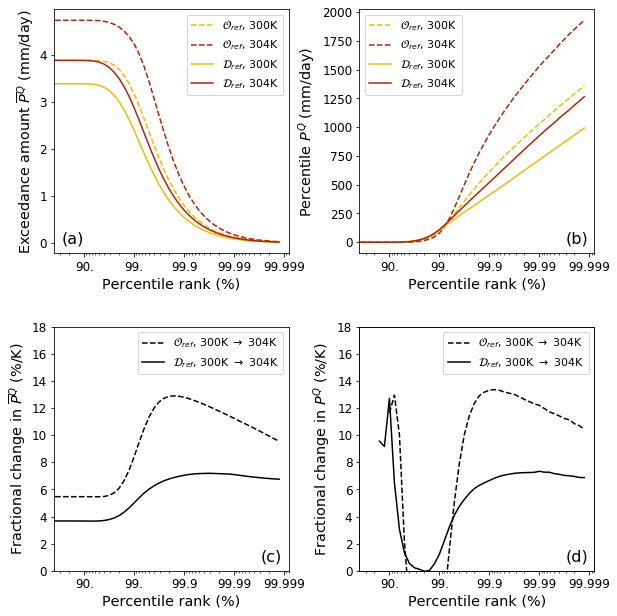

In [151]:
lt = ['--','-']

fig,axs = plt.subplots(ncols=2,nrows=2,figsize=(10,10))

SST_inds = (0,2)
# SST_inds = (1,3)
SSTs2plot = SSTs[SST_inds[0]],SSTs[SST_inds[1]]
sim_inds = np.array((0,4))

# ranks2show = ranks_9999
# sQ2show = sQ9999
ranks2show = ranks_99999
sQ2show = sQ99999
iQshow_max = 99.999
    
for i_sim in sim_inds:
    
    for i_SST in SST_inds:
        
        SST = SSTs[i_SST]
    
        simname = simname_patterns[i_sim]%(SST,realiz[SST][i_sim])
        simlab = simtype_labels[i_sim]+', %dK'%SST
        print(simname)

#         cdf_invlog = pr_mean[simname]*cdf_invlog_ILQ_pr[simname]
        invCDF_show = mean_pr[simname]*distributions[simname].invCDF[sQ2show]
        perc_show = distributions[simname].percentiles[sQ2show]

        # panel (a)
        subplotRanksILog(axs[0,0],ranks2show,
                         invCDF_show,
                         col=SST_col[i_SST],
                         ltype=simtype_linetype[i_sim],
                         labels=simlab,
                         transformX=False)
        
        # panel (b)
        subplotRanksILog(axs[0,1],ranks2show,
                         perc_show,
                         col=SST_col[i_SST],
                         ltype=simtype_linetype[i_sim],
                         labels=simlab,
                         transformX=False)


    key = "%s_%s"%(simname_patterns[i_sim]%(SSTs2plot[0],realiz[SSTs2plot[0]][i_sim]),
                   simname_patterns[i_sim]%(SSTs2plot[1],realiz[SSTs2plot[1]][i_sim]))
    keylabel = simtype_labels[i_sim]+r", %dK $\rightarrow$ %dK"%tuple(SSTs2plot)

    # panel (c)
    subplotRanksILog(axs[1,0],ranks2show,
                     fracchange_camountIL[key][sQ2show],
                     col='k',
                     ltype=simtype_linetype[i_sim],
                     labels=keylabel,
                     transformX=False)
    
    # panel (d)
    subplotRanksILog(axs[1,1],ranks2show,
                     fracchange_percIL[key][sQ2show],
                     col='k',
                     ltype=simtype_linetype[i_sim],
                     labels=keylabel,
                     transformX=False)


x = np.flipud(1./(1-ranks2show/100.))
# Deal with np.nans at the beginning of panel (d)
addYLine(axs[1,1],x,y0=-35)

for ax in axs.flatten():
    # add legend
    ax.legend(fontsize=11)
    # add x labels
    ax.set_xlabel('Percentile rank (%)')
#     # transform x axis
#     transformXaxisIL(ax,x,offset=0)
#     # crop axis
#     iQ_min = 4
# #     iQ_min = 14
#     ax.set_xlim((x[iQ_min-1],0.8))

    ax.invert_xaxis()
    iQ_min = 4
    ax.set_xlim((x[iQ_min-1],0.8))
    labels = [item.get_text() for item in ax.get_xticklabels()]
    n = ceil(log10(x.max()))
    offset = 1
    N = len(labels)
    for i in range(1,N):
        labels[-n+i-4+offset] = ("%2.7f"%(100*(1-10**(-n+i-1)))).rstrip('0')
        if -n+i-1 == 0:
            break
    ax.set_xticklabels(labels)

    
axs[0,0].set_ylabel(r'Exceedance amount $\overline{P}^Q$ (mm/day)')
axs[0,1].set_ylabel(r'Percentile $P^Q$ (mm/day)')
axs[1,0].set_ylabel(r'Fractional change in $\overline{P}^Q$ (%/K)')
axs[1,1].set_ylabel(r'Fractional change in $P^Q$ (%/K)')

axs[1,0].set_ylim((0,18))
axs[1,1].set_ylim((0,18))

##-- Panel numbers
axs[0,0].text(0.03,0.04,'(a)',transform = axs[0,0].transAxes,fontsize=16)
axs[0,1].text(0.88,0.04,'(b)',transform = axs[0,1].transAxes,fontsize=16)
axs[1,0].text(0.88,0.04,'(c)',transform = axs[1,0].transAxes,fontsize=16)
axs[1,1].text(0.88,0.04,'(d)',transform = axs[1,1].transAxes,fontsize=16)

plt.savefig(os.path.join(figuredir,'Figure3_distributions_org_disorg_%d_%d.pdf'%tuple(SSTs2plot)),
                bbox_inches='tight')

plt.show()

## Figure 4 (new) - Pext vs. Pmean

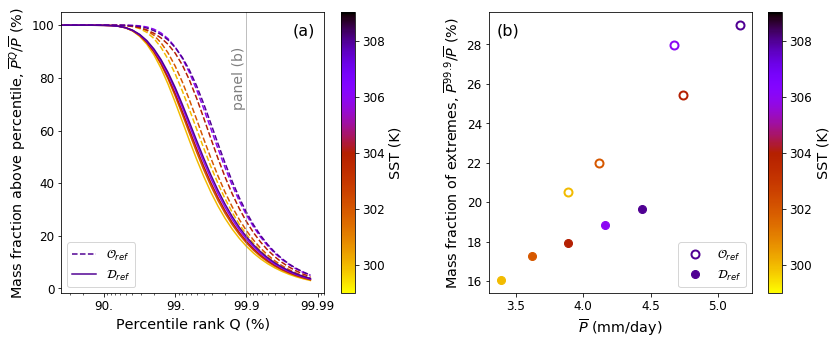

In [44]:
simtype_col = 'k','b','r','g','k'
sims2exclude = [(0,1),(0,2),(1,2),(2,2)]

# coloring SSTs
cmap = plt.cm.gnuplot_r
SSTmin = 299.
SSTmax = 309.
SST_col = [cmap(i) for i in (SSTs-np.array(SSTmin))/(SSTmax-SSTmin)]



fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(14,5))

##--- panel (a) normalized exceedance amounts (mass fraction of extremes)

ax = axs[0]

for i_SST in range(n_SSTs):
    
    SST = SSTs[i_SST]
    
    for i_sim in (0,4):
        
        simname = simname_patterns[i_sim]%(SST,realiz[SST][i_sim])
        simtype = simtypes[i_sim]
        
#         norm_cdf_IL_prQ = cdf_invlog_ILQ_pr[simname]*100
        invCDF_show = distributions[simname].invCDF[sQ2show]*100
        
        # Define legend label
        if SST == SSTs[-1]:
            lab = simtype_labels[i_sim]
        else:
            lab = ''

        subplotRanksILog(ax,ranks2show,
                         invCDF_show,
                         col=SST_col[i_SST],
                         labels=lab,
                         ltype=simtype_linetype[i_sim],
                         transformX=False)
        
# Line for correspondence with panel (b)
x = np.flipud(1./(1-ranks2show/100.))
ax.axvline(x=x[iQref],ymin=-2,ymax=102,linewidth=0.5,c='gray')
ax.text(x[iQref-2], 80, 'panel (b)', rotation=90, va='center',fontsize=14,c='grey')

# Panel number
# ax.text(x[iQref+7],0.9,'(a)',transform = ax.transAxes,fontsize=16)

# add x labels
ax.set_xlabel('Percentile rank Q (%)')
# transform x axis
transformXaxisIL(ax,x)
# crop axis
iQ_min = 4
ax.set_xlim((x[iQ_min-1],0.8))
    
# ax.set_ylabel(r'Extreme precipitation $P^{99.9-99.99}$ (mm/day)')
ax.set_ylabel(r'Mass fraction above percentile, $\overline{P}^{Q}/\overline{P}$ (%)')
ax.legend(loc='lower left',fontsize=12)

# Color bar
cax, _ = matplotlib.colorbar.make_axes(ax)
normalize = matplotlib.colors.Normalize(vmin=SSTmin, vmax=SSTmax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)
cax.set_ylabel('SST (K)')


##--- panel (b) unevenness for Oref and Dref

ax = axs[1]

for i_SST in range(n_SSTs):
    
    SST = SSTs[i_SST]
    
#     for i_sim in range(n_sims):
    for i_sim in (0,4):
        
        simname = simname_patterns[i_sim]%(SST,realiz[SST][i_sim])
        simtype = simtypes[i_sim]
        
        # Skip dot/curve if simulation didn't reach equilibrium
        if (i_SST,i_sim) in sims2exclude:
            print("passing %s"%simname)
            continue
        
        if simname in distributions.keys():
#             print("%dK, %s:"%(SST,simtype_labels[i_sim]),perc_ILQ_pr[simname][iQref])
#             x,y = SST,perc_ILQ_pr[simname][iQmax]
            # Mean over percentiles
#             x = pr_mean[simname]
            x = mean_pr[simname]
#             y = np.mean(perc_ILQ_pr[simname][sQext])
            y = distributions[simname].invCDF[iQref]*100

            #--- Draw points
            # Define color
            if i_sim in (0,1,2):
                mfc = 'none'
            else:
                mfc = SST_col[i_SST]
            # Define marker width
            mw = 1
            if i_sim == 0:
                mw = 2
            # Define legend label
            if SST == SSTs[-1]:
                lab = simtype_labels[i_sim]
            else:
                lab = ''
            # Show point
            ax.plot(x,y,simtype_markers[i_sim], ms=8, markerfacecolor=mfc,markeredgecolor=SST_col[i_SST],\
                    markeredgewidth=mw,label=lab)
            
ax.set_xlabel(r'$\overline{P}$ (mm/day)')
# ax.set_ylabel(r'Extreme precipitation $P^{99.9-99.99}$ (mm/day)')
ax.set_ylabel(r'Mass fraction of extremes, $\overline{P}^{99.9}/\overline{P}$ (%)')
ax.legend(fontsize=12,loc='lower right')

# Color bar
cax, _ = matplotlib.colorbar.make_axes(ax)
normalize = matplotlib.colors.Normalize(vmin=SSTmin, vmax=SSTmax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)
cax.set_ylabel('SST (K)')


##-- Panel numbers
axs[0].text(0.88,0.92,'(a)',transform = axs[0].transAxes,fontsize=16)
axs[1].text(0.03,0.92,'(b)',transform = axs[1].transAxes,fontsize=16)

plt.savefig(os.path.join(figuredir,'Figure4.pdf'),
                bbox_inches='tight')
plt.show()

## Figure 5

In [57]:
print('Linearly regressed fractional changes in rainfall intensities and exceedance amounts')

sims2exclude = [(0,1),(0,2),(1,2),(2,2)]

fracchange_mean_camountIL = {}
fracchange_mean_percIL = {}
fracchange_mean_prmean = {}
offset_camountIL = {}
offset_percIL = {}
offset_prmean = {}

# for i_sim in range(n_sims):
for i_sim in (0,4):
    
    key = simtypes[i_sim]
    print(' .  ',key)
    
    fracchange_mean_camountIL[key] = np.nan*np.zeros((iQmax,))
    offset_camountIL[key] = np.nan*np.zeros((iQmax,))
    fracchange_mean_percIL[key] = np.nan*np.zeros((iQmax,))
    offset_percIL[key] = np.nan*np.zeros((iQmax,))
        
    # SSTs to consider
    sst_values = []
    for i_SST in range(n_SSTs):
        
#         if (i_SST,i_sim) in sims2exclude:
            
#             print(simname_patterns[i_sim]%(SSTs[i_SST],realiz[SSTs[i_SST]][i_sim]),'excluded')
            
        
        if not (i_SST,i_sim) in sims2exclude:

            sst_values.append(SSTs[i_SST])
    
    # For each percentile, do the calculation
    for iQ in range(iQmax):        
    
        percIL_values = []
        camountIL_values = []

        # For each SST, store precip data
        for SST in sst_values:
            
            simname = simname_patterns[i_sim]%(SST,realiz[SST][i_sim])
            
#             camountIL_values.append(pr_mean[simname]*cdf_invlog_ILQ_pr[simname][iQ])
#             percIL_values.append(perc_ILQ_pr[simname][iQ])
            camountIL_values.append(mean_pr[simname]*distributions[simname].invCDF[iQ])
            percIL_values.append(distributions[simname].percentiles[iQ])

        # Regress ln(pr) against T for percentiles
        slope, intercept, r_value, p_value, std_err = stats.linregress(sst_values,np.log(percIL_values))
        fracchange_mean_percIL[key][iQ] = slope
        offset_percIL[key][iQ] = intercept
        # Regress ln(pr) against T for rain amounts
        slope, intercept, r_value, p_value, std_err = stats.linregress(sst_values,np.log(camountIL_values))
        fracchange_mean_camountIL[key][iQ] = slope
        offset_camountIL[key][iQ] = intercept
    
    prmean_values = []
    # For each SST, store precip data
    for SST in sst_values:
        simname = simname_patterns[i_sim]%(SST,realiz[SST][i_sim])
#         prmean_values.append(pr_mean[simname])
        prmean_values.append(mean_pr[simname])

    # Regress ln(pr) against T for mean rain 
    slope, intercept, r_value, p_value, std_err = stats.linregress(sst_values,np.log(prmean_values))
    fracchange_mean_prmean[key] = slope
    offset_prmean[key] = intercept
        


Linearly regressed fractional changes in rainfall intensities and exceedance amounts
 .   simOref
 .   simDref


/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in log
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/numpy/lib/function_base.py:2449: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1-b150-sfcagg
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1-b150-sfcdisagg
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-r2-b150-sfcdisagg
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-r1-b150-sfcdisagg
[1395.35363815 1548.26275787 1967.51723774 2190.20488373 2440.99211462]
[1018.83439584 1181.30596293 1303.84777124 1485.14076736 1668.33245325]
0.05893
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1-b150-sfcagg
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1-b150-sfcdisagg
0.05893
0.05805
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-r2-b150-sfcdisagg
0.05805
0.05719
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-r1-b150-sfcdisagg
0.05719
0.05634
0.05634
0.05551
0.05551


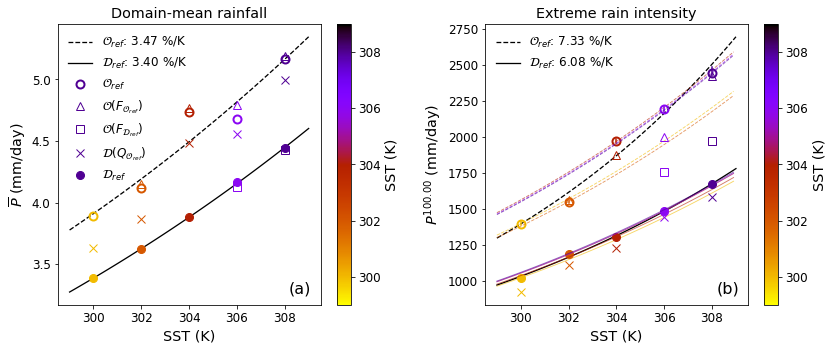

In [170]:
simtype_col = 'k','b','r','g','k'
sims2exclude = [(0,1),(0,2),(1,2),(2,2)]

# iQext = iQref + 10
iQext = iQref + 20

def getExponentialSSTCurve(i_sim,slopes,offsets,iQ=None):

    simtype = simtypes[i_sim]
    # SSTs to consider
    sst_values = []
    for i_SST in range(n_SSTs):
        if not (i_SST,i_sim) in sims2exclude:
            sst_values.append(SSTs[i_SST])
    sst_values = np.array(sst_values)
    # curve points
    x = np.linspace(sst_values[0]-1,sst_values[-1]+1,100)
    if iQ is None:
        y = np.exp(slopes[simtype]*x + offsets[simtype])
    else:
        y = np.exp(slopes[simtype][iQ]*x + offsets[simtype][iQ])
    
    return x,y
    
# legend font size
ftsize = 12
# coloring SSTs
cmap = plt.cm.gnuplot_r
SSTmin = 299.
SSTmax = 309.
SST_col = [cmap(i) for i in (SSTs-np.array(SSTmin))/(SSTmax-SSTmin)]

# Compute CC rates at each temperature
dT = 0.1
x_vals = np.arange(SSTs[0]-1,SSTs[-1]+1,dT)
rate = 0.08
# y_vals_norm = np.exp(rate*x_vals)
y_vals_ref = saturationVaporPressure(temp=x_vals)


fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(14,5))

##---- Panel (a): mean P
ax = axs[0]
# ax.set_ylim((3.2,5.9))

##--- Draw exponential fits
for i_sim in range(n_sims):

    if i_sim in (0,4):

        simtype = simtypes[i_sim]

        x_ssts,y_pr = getExponentialSSTCurve(i_sim,fracchange_mean_prmean,offset_prmean)

#         lab = 'Exponential fit, '+simtype_labels[i_sim]+'%2.2f'%(fracchange_mean_prmean[simtype]*100)+'%/K'
#         lab = 'Exponential trend, '+simtype_labels[i_sim]+': %2.2f'%(fracchange_mean_prmean[simtype]*100)+' %/K'
        lab = simtype_labels[i_sim]+': %2.2f'%(fracchange_mean_prmean[simtype]*100)+' %/K'
        ax.plot(x_ssts,y_pr,linestyle=simtype_linetype[i_sim],linewidth=1.3,c='k',label=lab)

for i_SST in range(n_SSTs):

    SST = SSTs[i_SST]

    for i_sim in range(n_sims):

        simname = simname_patterns[i_sim]%(SST,realiz[SST][i_sim])

        if (i_SST,i_sim) in sims2exclude:
            print("passing %s"%simname)
            continue

        if simname in mean_pr.keys():

#             x,y = SST,pr_mean[simname]
            x,y = SST,mean_pr[simname]
            
            #--- Draw points
            # Define color
            if i_sim in (0,1,2):
                mfc = 'none'
            else:
                mfc = SST_col[i_SST]
            # Define marker width
            mw = 1
            if i_sim == 0:
                mw = 2
            # Define legend label
            if SST == SSTs[-1]:
                lab = simtype_labels[i_sim]
            else:
                lab = ''
            # Show point
            ax.plot(x,y,simtype_markers[i_sim], ms=8, markerfacecolor=mfc,markeredgecolor=SST_col[i_SST],\
                    markeredgewidth=mw,label=lab)

ax.legend(fontsize=ftsize,framealpha=0)

##---- Panel (b): extreme P ----##
ax = axs[1]
# ax.set_ylim((450,1850))

##--- Draw exponential fits
for i_sim in range(n_sims):

    simtype = simtypes[i_sim]

    if i_sim in (0,4):
#             x_ssts,y_pr = getExponentialSSTCurve(i_sim,fracchange_mean_percIL,offset_percIL,iQref)
        #-- Recompute manually

        # SSTs 
        sst_values = []
        pr_values = []
        for i_SST in range(n_SSTs):
            if not (i_SST,i_sim) in sims2exclude:
                sst_values.append(SSTs[i_SST])
                simname = simname_patterns[i_sim]%(SSTs[i_SST],realiz[SSTs[i_SST]][i_sim])
                
                # extreme P
#                 pr_values.append(np.mean(perc_ILQ_pr[simname][sQext]))
#                 pr_values.append(np.mean(distributions[simname].percentiles[sQext]))
                # 99.9th percentile
                pr_values.append(distributions[simname].percentiles[iQext])
                
        sst_values = np.array(sst_values)
        pr_values = np.array(pr_values)
        print(pr_values)
        # exp fit
        slope, intercept, r_value, p_value, std_err = stats.linregress(sst_values,np.log(pr_values))
        #-- Values to plot
        x_ssts = np.linspace(sst_values[0]-1,sst_values[-1]+1,100)
        y_pr = np.exp(slope*x_ssts+intercept)
        # Draw
#         lab = 'Exponential trend, '+simtype_labels[i_sim]+': %2.2f'%(slope*100)+' %/K'
        lab = simtype_labels[i_sim]+': %2.2f'%(slope*100)+' %/K'
        ax.plot(x_ssts,y_pr,linestyle=simtype_linetype[i_sim],linewidth=1.3,c='k',label=lab)

        
##--- Draw points and CC curves
for i_SST in range(n_SSTs):
    
    SST = SSTs[i_SST]
    
    for i_sim in range(n_sims):
        
        simname = simname_patterns[i_sim]%(SST,realiz[SST][i_sim])
        simtype = simtypes[i_sim]
        
        # Skip dot/curve if simulation didn't reach equilibrium
        if (i_SST,i_sim) in sims2exclude:
            print("passing %s"%simname)
            continue
        
        if simname in distributions.keys():

            # Mean over percentiles
#             x,y = SST,np.mean(perc_ILQ_pr[simname][sQext])
#             x,y = SST,np.mean(distributions[simname].percentiles[sQext])
            # Reference 99.9th percentile
#             x,y = SST,perc_ILQ_pr[simname][iQref]
            x,y = SST,distributions[simname].percentiles[iQext]
            
            #--- Draw error bar
            if i_sim in (0,4):
                y1 = distributions[simname].percentiles_Q1[iQext]
                y2 = distributions[simname].percentiles_Q3[iQext]
                ax.plot([x,x],[y1,y2],c=SST_col[i_SST])
        
            #--- Draw CC curve
            if i_sim in (0,4):
                # Assuming a fixed rate
    #             y_vals = y_vals_norm*y*np.exp(-rate*x)

                # Assuming the CC formula
                i_x = np.argmin(np.abs(x_vals - float(SST)))
                y_vals = y_vals_ref/y_vals_ref[i_x]*y
                print("%2.5f"%((np.diff(y_vals)[i_x]/y_vals[i_x])/dT))

                ax.plot(x_vals,y_vals,linestyle=simtype_linetype[i_sim],\
                        c=SST_col[i_SST],linewidth=0.9,alpha=0.6)
                
            #--- Draw points
            # Define color
            if i_sim in (0,1,2):
                mfc = 'none'
            else:
                mfc = SST_col[i_SST]
            # Define marker width
            mw = 1
            if i_sim == 0:
                mw = 2
            # Define legend label
            if SST == SSTs[-1]:
#                 lab = simtype_labels[i_sim]
                lab = ''
            else:
                lab = ''
            # Show point
            ax.plot(x,y,simtype_markers[i_sim], ms=8, markerfacecolor=mfc,markeredgecolor=SST_col[i_SST],\
                    markeredgewidth=mw,label=lab)

for ax in axs:
    
    ax.set_xlabel('SST (K)')
    
    # Color bar
    cax, _ = matplotlib.colorbar.make_axes(ax)
    normalize = matplotlib.colors.Normalize(vmin=SSTmin, vmax=SSTmax)
    cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize,label='SST (K)')

axs[0].set_ylabel(r'$\overline{P}$ (mm/day)')
# axs[1].set_ylabel(r'99.9th percentile $P^{99.9}$ (mm/day)')
axs[1].set_ylabel(r'$P^{%2.2f}$ (mm/day)'%ranks[iQext])

axs[0].set_title(r'Domain-mean rainfall')
axs[1].set_title(r'Extreme rain intensity')

# axs[1].legend(ncol=2,fontsize=11)
axs[1].legend(ncol=1,fontsize=ftsize,framealpha=0)

##-- Panel numbers
axs[0].text(0.88,0.04,'(a)',transform = axs[0].transAxes,fontsize=16)
axs[1].text(0.88,0.04,'(b)',transform = axs[1].transAxes,fontsize=16)

plt.savefig(os.path.join(figuredir,'meanP_P%s_vs_SST_allsims.pdf'%str(ranks[iQext]).replace('.','')[:5]),
                bbox_inches='tight')
plt.show()

## Figure 6 (new, in section 4, replacing Table 2) - enhancement factors as a function of SST (for Pbar, Pext and dcc)

In [152]:
# Enhancement factors
ef_names = 'full','radiative feedback','mean climate shift org','surface-flux feedback','mean climate shift disorg','circulation total'
ef_labels = r'$\mathcal{E}_{\mathrm{total}}$',\
    r'$\mathcal{E}_{\mathrm{rad}}$',\
    r'$\mathcal{E}_{\mathrm{shift\mathcal{F}}}$',\
    r'$\mathcal{E}_{\mathrm{surf}}$',\
    r'$\mathcal{E}_{\mathrm{shift\mathcal{Q}}}$',\
    r'$\mathcal{E}_{\mathrm{circ}}$'
ef_lon_labels = 'Total',\
                 'Radiatively-driven circulation',\
                 'Mean shift in surface fluxes',\
                 'Surface-feedback reinforced circulation',\
                 'Mean shift in radiative cooling',\
                 'Circulation + its mean climate effects'

ef_inds = (0,4),(2,4),(1,2),(0,1),(3,4),(0,3)
n_ef = len(ef_names)
ef_cols = 'k','orange','r','darkblue','steelblue','g'
# ef_markers = r'$t$',r'$r$',r'$F$',r's',r'$Q$',r'c'
ef_markers = "T","R","F","S","Q","C"

SST_ef_2exclude = (0,1),(0,2),(0,3),(1,1),(1,2)

In [180]:
print("compute values for enhancemnet factors for precipitation efficiency argument")

mean_pr_array = np.nan*np.zeros((n_SSTs,n_sims))
prQ_array = np.nan*np.zeros((n_SSTs,n_sims))
pr999_array = np.nan*np.zeros((n_SSTs,n_sims))
pr9999_array = np.nan*np.zeros((n_SSTs,n_sims))
pr99999_array = np.nan*np.zeros((n_SSTs,n_sims))

###--- Fixed climate quantities

for i_SST in range(n_SSTs):

    SST = SSTs[i_SST]
    
    for i_sim in range(n_sims):
    
        simname = simname_patterns[i_sim]%(SST,realiz[SST][i_sim])

        # mean of extremes
#         prQ = np.nanmean(perc_ILQ_pr[simname][sQext])
#         prQ_array[i_SST,i_sim] = prQ
        mean_pr_array[i_SST,i_sim] = mean_pr[simname]
        prQ_array[i_SST,i_sim] = np.mean(distributions[simname].percentiles[sQext])
        pr999_array[i_SST,i_sim] = distributions[simname].percentiles[iQ999]
        pr9999_array[i_SST,i_sim] = distributions[simname].percentiles[iQ9999]
        pr99999_array[i_SST,i_sim] = distributions[simname].percentiles[iQ99999]

        
###--- Fractional change quantities

# automate
def deltaFracChange(var_array):

    NSST, Nsims = var_array.shape

    fc_array = (var_array[1:,:]/var_array[:NSST-1,:] - 1)/2*100
    delta_fc_array = np.zeros((NSST-1,Nsims-1))
    for j in range(Nsims-1):
        delta_fc_array[:,j] = fc_array[:,j] - fc_array[:,-1]

    return delta_fc_array

# compute enhancement of each component in comparison with Dref
for key in 'prQ_array',:
    
    array = getattr(thismodule,key)
    NSST, Nsims = array.shape
    norm_array = np.nan*np.zeros((NSST,Nsims-1))
    for i_sim in range(Nsims-1):
        norm_array[:,i_sim] = array[:,i_sim]/array[:,-1]
    setattr(thismodule,"norm_%s"%key,norm_array)

# compute difference in fractional changes in each component with Dref
delta_mean_pr_array = deltaFracChange(mean_pr_array)
delta_prQ_array = deltaFracChange(prQ_array)
delta_pr999_array = deltaFracChange(pr999_array)
delta_pr9999_array = deltaFracChange(pr9999_array)
delta_pr99999_array = deltaFracChange(pr99999_array)


###--- Enhancement factors

def computeEnhancementFactors(X_array):
    
    """X_arrray contains statistics in SST-simtype space"""

    # initialize
    ef_array = np.nan*np.zeros((n_SSTs,n_ef))
    # compute
    for i_SST in range(n_SSTs):

        SST = SSTs[i_SST]

        for i_ef in range(n_ef):

            # Pass SST-EF pair to exclude
            if (i_SST,i_ef) in SST_ef_2exclude:
                continue

            # get average over extremes
            ef_array[i_SST,i_ef] = X_array[i_SST,ef_inds[i_ef][0]] / X_array[i_SST,ef_inds[i_ef][1]]

    return ef_array
    
def printEFArrayAsLatexTable(array):
    # Convert array to dataframe
    ef_df = pd.DataFrame(array)

    # Remove simulations to avoid
    for i_SST,i_ef in SST_ef_2exclude:
        ef_df.loc[i_SST,i_ef] = '-'

    # Replace row names
    row_names = dict(zip(range(n_SSTs),tuple(["%d K"%SST for SST in SSTs])))
    ef_df = ef_df.rename(row_names,axis='index')

    # Display in latex table format
    print(ef_df.to_latex(float_format=lambda x:"%.2f"%x))
    
    
# compute enhancement of each component in comparison with Dref
for key in 'mean_pr_array','prQ_array','pr999_array','pr9999_array','pr99999_array':
    
    array = getattr(thismodule,key)
    ef_array = computeEnhancementFactors(array)
    setattr(thismodule,"ef_%s"%key,ef_array)
    
    print()
    print('--------------- %s -----------------'%key)
    printEFArrayAsLatexTable(ef_array)
    


compute values for enhancemnet factors for precipitation efficiency argument

--------------- mean_pr_array -----------------
\begin{tabular}{lrlllrr}
\toprule
{} &    0 &    1 &    2 &    3 &    4 &    5 \\
\midrule
300 K & 1.15 &    - &    - &    - & 1.07 & 1.07 \\
302 K & 1.14 &    - &    - & 0.99 & 1.07 & 1.06 \\
304 K & 1.22 & 0.98 & 1.25 & 0.99 & 1.15 & 1.06 \\
306 K & 1.12 & 0.99 & 1.16 & 0.98 & 1.09 & 1.03 \\
308 K & 1.16 & 1.00 & 1.17 & 1.00 & 1.12 & 1.03 \\
\bottomrule
\end{tabular}


--------------- prQ_array -----------------
\begin{tabular}{lrlllrr}
\toprule
{} &    0 &    1 &    2 &    3 &    4 &    5 \\
\midrule
300 K & 1.47 &    - &    - &    - & 0.94 & 1.57 \\
302 K & 1.45 &    - &    - & 1.03 & 0.96 & 1.51 \\
304 K & 1.74 & 1.18 & 1.35 & 1.09 & 0.98 & 1.77 \\
306 K & 1.68 & 1.27 & 1.19 & 1.11 & 1.01 & 1.67 \\
308 K & 1.72 & 1.31 & 1.28 & 1.03 & 0.99 & 1.74 \\
\bottomrule
\end{tabular}


--------------- pr999_array -----------------
\begin{tabular}{lrlllrr}
\toprule
{}

Show enhancement factors for all SSTs at extreme percentiles vs. SST


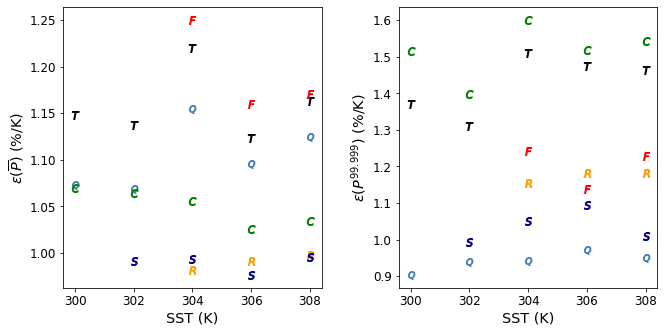

In [181]:

print("Show enhancement factors for all SSTs at extreme percentiles vs. SST")


# ef2show_all = [getattr(thismodule,'ef_%s_array'%pr_lab) for pr_lab in ['mean_pr','prQ']]
# labels = ['\overline{P}','P^Q']

ef2show_all = [getattr(thismodule,'ef_%s_array'%pr_lab) for pr_lab in ['mean_pr','pr99999']]
labels = ['\overline{P}','P^{99.999}']

dSST = 2

fig,axs = plt.subplots(ncols=2,figsize=(11,5))

for ax,ef2show,lab in zip(axs,ef2show_all,labels):

    for i_SST in range(5):

        SST = SSTs[i_SST]

        Nc = 0

        for i_ef in range(n_ef):

            Nc += 1 # Count to reverse x axis once reach last curve

    #         if (i_SST,ef_inds[i_ef][0]) in sims2exclude:
    #             print("passing %s"%simname)
    # #             print(' passing')
    #             continue

            col = SST_col[i_SST]

            # Show points
            if i_sim in (0,1,2):
                mfc = 'none'
            else:
                mfc = col
            col = ef_cols[i_ef]
            mw = 1
            if i_sim == 0:
                mw = 2

            # x
            x = SST

            # y
            y = ef2show[i_SST,i_ef]

            ax.plot(x,y,marker="$ {} $".format(ef_markers[i_ef]), ms=8, markerfacecolor=mfc,markeredgecolor=col, markeredgewidth=mw)


    # ax.legend(loc='lower left',fontsize=11)
    ax.set_xlabel('SST (K)')
    ax.set_ylabel(r'$\varepsilon (%s)$ (%%/K)'%lab)
    ax.set_xlim((SSTs[0]-0.4,SSTs[-1]+0.4))

# plt.savefig(os.path.join(figuredir,'fracchange_ef_%s_vs_SST.pdf'%ext_lab),
#             bbox_layout='tight')
plt.show()
    







# # Save boundaries for legend
# x,y,w,h = ax.get_position().bounds
# x_left = np.nanmin(np.array([x,x_left]))
# x_right = np.nanmax(np.array([x+w,x_right]))
# y_bot = np.nanmin(np.array([y,y_bot]))
# y_top = np.nanmax(np.array([y+h,y_top]))

Show change in enhancement factors for all pairs of adjacent SSTs at extreme percentiles vs. SST


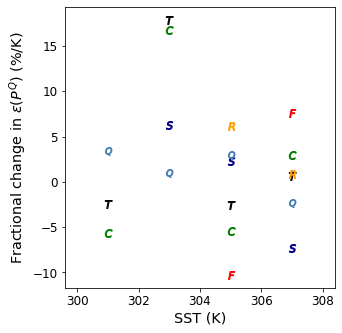

In [178]:

print("Show change in enhancement factors for all pairs of adjacent SSTs at extreme percentiles vs. SST")

ext_lab = 'pr9999'
ef2show = getattr(thismodule,'ef_%s_array'%ext_lab)
# ef2show_all = [getattr(thismodule,'ef_%s_array'%pr_lab) for pr_lab in ['mean_pr','pr999']]
# labels = ['\overline{P}','P^{99.9}']

dSST = 2

fig,ax = plt.subplots(ncols=1,figsize=(5,5))

for i_SST in range(4):
    
    SST = SSTs[i_SST]

    Nc = 0

    for i_ef in range(n_ef):
        
        Nc += 1 # Count to reverse x axis once reach last curve
        
#         if (i_SST,ef_inds[i_ef][0]) in sims2exclude or (i_SST,ef_inds[i_ef][1]) in sims2exclude:
#             print("passing %s"%simname)
# #             print(' passing')
#             continue

        col = SST_col[i_SST]

        # Show points
        if i_sim in (0,1,2):
            mfc = 'none'
        else:
            mfc = col
        col = ef_cols[i_ef]
        mw = 1
        if i_sim == 0:
            mw = 2

        # x
        x = SST+dSST/2
        
        # y
        ef_cold = ef2show[i_SST,i_ef]
        ef_warm = ef2show[i_SST+1,i_ef]
        y = (ef_warm/ef_cold-1)*100
        
        ax.plot(x,y,marker="$ {} $".format(ef_markers[i_ef]), ms=8, markerfacecolor=mfc,markeredgecolor=col, markeredgewidth=mw)


# ax.legend(loc='lower left',fontsize=11)
ax.set_xlabel('SST (K)')
ax.set_ylabel(r'Fractional change in $\varepsilon (P^Q)$ (%/K)')
ax.set_xlim((SSTs[0]-0.4,SSTs[-1]+0.4))

plt.savefig(os.path.join(figuredir,'fracchange_ef_%s_vs_SST.pdf'%ext_lab),
            bbox_layout='tight')
plt.show()
    







# # Save boundaries for legend
# x,y,w,h = ax.get_position().bounds
# x_left = np.nanmin(np.array([x,x_left]))
# x_right = np.nanmax(np.array([x+w,x_right]))
# y_bot = np.nanmin(np.array([y,y_bot]))
# y_top = np.nanmax(np.array([y+h,y_top]))

# Supplementary figures

## Fig S1 - timeseries of PW or Prec to show convergence / oscillations in organized regimes

In [65]:
print("Compare LHF and L*P in organized and disorganized runs")

i_sim = 0
print('sim:%s'%simname_patterns[i_sim])

for SST in SSTs:
    sim = simname_patterns[i_sim]%(SST,realiz[SST][i_sim])
    print('LHF =',np.mean(data_mean_t[sim].LHF[-ndays*24:]))

Compare LHF and L*P in organized and disorganized runs
sim:RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST%d-r%d


AttributeError: 'Dataset' object has no attribute 'LHF'

simulation pattern: RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST%d-radhomo-r%d


KeyError: 'RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-radhomo-r1'

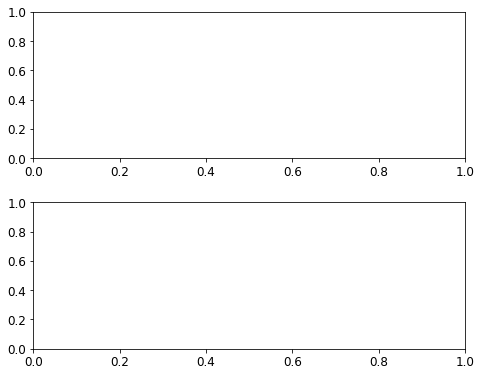

In [171]:

print('simulation pattern: %s'%simname_patterns[i_sim])
SSTmin = 299.
SSTmax = 309.
SST_col = [cmap(i) for i in (SSTs-np.array(SSTmin))/(SSTmax-SSTmin)]

varid = 'PW'

Nhrs = 48
fig, axs = plt.subplots(nrows=2,figsize=(8,6))

# Dref
i_sim = 4 # reference organized
ax = axs[0]

for i_SST in range(len(SSTs)):

    SST = SSTs[i_SST]
    simname = simname_patterns[i_sim]%(SST,realiz[SST][i_sim])

    data = data_mean_t[simname]
    s_filt = slice(24,24*min(100,len(data.time))-24)
    x = data.time[s_filt]
    y = np.convolve(data[varid],np.ones(Nhrs)/Nhrs,'same')[s_filt]
    ax.plot(x,y,c=SST_col[i_SST],alpha=0.5)
    
ax.set_ylabel('%s (%s)'%(varid,data[varid].units))
ax.set_title(r'$\mathcal{D}_{ref}$')

# Oref
i_sim = 0 # reference organized
ax = axs[1]

for i_SST in range(len(SSTs)):

    SST = SSTs[i_SST]
    simname = simname_patterns[i_sim]%(SST,realiz[SST][i_sim])
    
    data = data_mean_t[simname]
    s_filt = slice(24,24*min(150,len(data.time))-24)
    x = data.time[s_filt]
    y = np.convolve(data[varid],np.ones(Nhrs)/Nhrs,'same')[s_filt]
    ax.plot(x,y,c=SST_col[i_SST],alpha=0.4)

ax.set_ylabel('%s (%s)'%(varid,data[varid].units))
ax.set_title(r'$\mathcal{O}_{ref}$')

ax.set_xlabel('Time (days)')

plt.savefig(os.path.join(figuredir,'timeseries_%s_filtered%dh_%d.pdf'%(varid,Nhrs,i_sim)),
           bbox_inches='tight')
plt.savefig(os.path.join(figuredir,'FigureS1.pdf'),bbox_inches='tight')

Text(0, 0.5, 'Mean P (mm/day)')

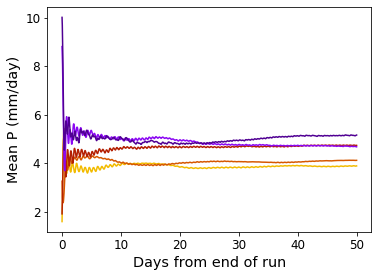

In [21]:
i_sim = 0 # reference organized
SSTmin = 299.
SSTmax = 309.
SST_col = [cmap(i) for i in (SSTs-np.array(SSTmin))/(SSTmax-SSTmin)]

varid = 'Prec'
s = slice(None,50*24)

fig, ax = plt.subplots()
for i_SST in range(len(SSTs)):
    
    SST = SSTs[i_SST]
    simname = simname_patterns[i_sim]%(SST,realiz[SST][i_sim])
    
    data = data_mean_t[simname]
    ax.plot(data.time[s],np.cumsum(np.flipud(data[varid]))[s]/range(1,len(data.time)+1)[s],c=SST_col[i_SST])
    
ax.set_xlabel('Days from end of run')
ax.set_ylabel('Mean P (mm/day)')

## Fig S2 - LHF, SHF, int Qrad vs. SST

passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1-b150-sfcagg
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1-b150-sfcdisagg
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-r1-b150-sfcdisagg
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-r1-b150-sfcdisagg


KeyError: 'SHF'

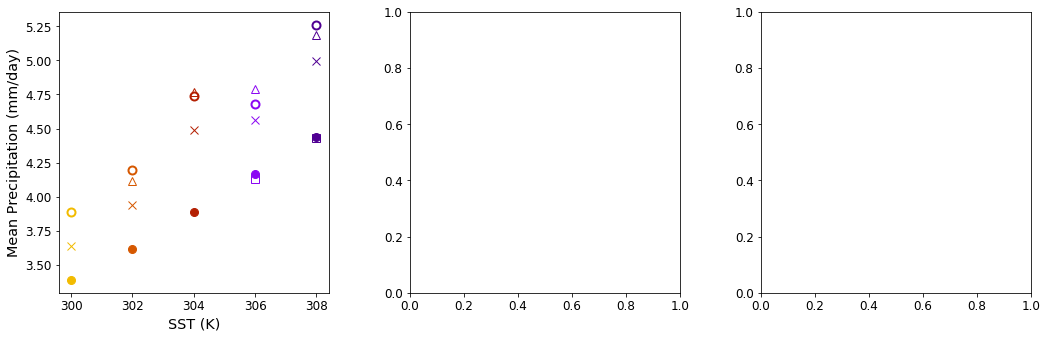

In [217]:
simtype_col = 'k','b','r','g','k'

# Var to plot
varids = 'Prec','SHF', 'LHF'
varlabels = 'Mean Precipitation', 'Sensible Heat Flux','Latent Heat Flux'

# N days for averaging
ndays = 50

# coloring SSTs
cmap = plt.cm.gnuplot_r
SSTmin = 299.
SSTmax = 309.
SST_col = [cmap(i) for i in (SSTs-np.array(SSTmin))/(SSTmax-SSTmin)]

fig,axs = plt.subplots(nrows=1,ncols=len(varids),figsize=(18,5))

for i_var,ax in zip(range(len(varids)),axs):
    
    varid = varids[i_var]
    
    for i_SST in range(n_SSTs):

        SST = SSTs[i_SST]

        for i_sim in range(n_sims):

            simname = simname_patterns[i_sim]%SST

            if (i_SST,i_sim) in sims2exclude:
                print("passing %s"%simname)
                continue

            if simname in perc_ILQ_pr.keys():
                
                col = SST_col[i_SST]

                # Show points
                if i_sim in (0,1,2):
                    mfc = 'none'
                else:
                    mfc = col
                mw = 1
                if i_sim == 0:
                    mw = 2
                    
                x,y = SST,np.mean(data_mean_t[simname][varid][-ndays*24:])
                ax.plot(x,y,simtype_markers[i_sim], ms=8, markerfacecolor=mfc,markeredgecolor=col, markeredgewidth=mw)

    ax.set_xlabel('SST (K)')
    ax.set_ylabel(r'%s (%s)'%(varlabels[i_var],data_mean_t[simname][varid].units))

# # Color bar
# cax, _ = matplotlib.colorbar.make_axes(ax)
# normalize = matplotlib.colors.Normalize(vmin=SSTmin, vmax=SSTmax)
# cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)

plt.savefig(os.path.join(figuredir,'FigureS2.pdf'),bbox_inches='tight')
plt.show()

## Figure S3 - PQ vs. Q with scaling approximation at all SSTs

## Figure S4 - Fractional changes of M, Gamma, epsilon for adjacent pairs of SSTs

## Figure S5 - Another illustration of enhancement factors on the bottom path, for the unevenness of precipitation (fractional change in amount fraction)

In [15]:
simname_patterns

('RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST%d-r1',
 'RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST%d-r1-b150-sfcagg',
 'RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST%d-r1-b150-sfcdisagg',
 'RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST%d-radhomo-r1-b100-radagg',
 'RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST%d-radhomo-r1')

In [30]:
print("Show amount fraction for all runs at all SSTs")

lt = ['--','--','--','-','-']
col = ['k','r','y','deepskyblue','k']

s = sQ
Nc = 0
for i_SST in range(5):
    
    SST = SSTs[i_SST]
    
    fig,ax = plt.subplots(ncols=1,figsize=(5,5))
    # ax.set_ylim((-0.2,25.2))

    for i_sim in range(5):
        
        Nc += 1 # Count to reverse x axis once reach last curve
        
        if (i_SST,i_sim) in sims2exclude:
            print("passing %s"%simname)
            continue
        
        simname = simname_patterns[i_sim]%SST

        cdf_invlog = cdf_invlog_ILQ_pr[simname]*100

        subplotRanksILog(ax,ranks_9999,
                         cdf_invlog[sQ9999],
                         col=col[i_sim],
                         ltype=lt[i_sim],
                         labels=simtype_labels[i_sim],
                         transformX=Nc==5)

    ax.legend(loc='lower left',fontsize=11)
    ax.set_xlabel('Percentile rank Q (%)')
    ax.set_ylabel(r'Rain mass fraction above $P^Q$ (%)')
    ax.set_title('%d K'%SST)
    
    Nc = 0

    plt.savefig(os.path.join(figuredir,'cdf_invlog_%d.pdf'%SST),
                bbox_layout='tight')
    plt.close()
    


Show amount fraction for all runs at all SSTs
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-r1-b150-sfcagg
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-r1-b150-sfcagg


No handles with labels found to put in legend.


Show fractional change in amount fraction for all runs at 99.9th percentile for adjacent SSTs vs. SST
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST308-radhomo-r1
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST308-radhomo-r1
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST308-radhomo-r1
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST308-radhomo-r1


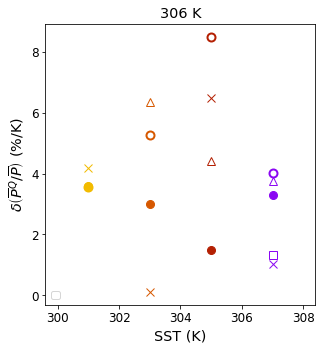

## Explore error bars on extremes